# Prime Trade: Trader Performance & Sentiment Analysis

**Objective:** To analyze historical trader data against market sentiment (Fear & Greed Index) to identify profitable trading behaviors and strategies. This report covers overall performance, risk analysis, and deep dives into specific trading styles like contrarian, high-leverage, and "whale" activity.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:

try:
    trader_df = pd.read_csv("csv_files/historical_data.csv")
    sentiment_df = pd.read_csv("csv_files/fear_greed_index.csv")
    print("Files loaded successfully.")
except FileNotFoundError:
    print("Make sure 'historical_data.csv' and 'fear_greed_index.csv' are in the correct folder.")

Files loaded successfully.


In [11]:
trader_df['Timestamp IST'] = pd.to_datetime(trader_df['Timestamp IST'], format='%d-%m-%Y %H:%M')
trader_df['date'] = trader_df['Timestamp IST'].dt.date
trader_df['date'] = pd.to_datetime(trader_df['date'])

sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

trader_df = trader_df.sort_values('date')
sentiment_df = sentiment_df.sort_values('date')

print("\nData cleaned and prepared for merging.")


Data cleaned and prepared for merging.


In [12]:

merged_df = pd.merge(trader_df, sentiment_df, on='date', how='inner')

all_trades = merged_df[merged_df['Closed PnL'] != 0].copy()

print("\nMerged Data Sample:")


Merged Data Sample:


## 1. Overall Market Analysis: When are Trades Most Profitable?

First, let's get a high-level view of the market. This analysis groups all trades to see, on average, which sentiment conditions have been the most profitable.

In [13]:

avg_profit_by_sentiment = all_trades.groupby('classification')['Closed PnL'].mean()
print("\n--- Average Profit by Sentiment Category ---")
print(avg_profit_by_sentiment)


--- Average Profit by Sentiment Category ---
classification
Extreme Fear      71.027316
Extreme Greed    130.205309
Fear             112.625988
Greed             85.403927
Neutral           71.199993
Name: Closed PnL, dtype: float64


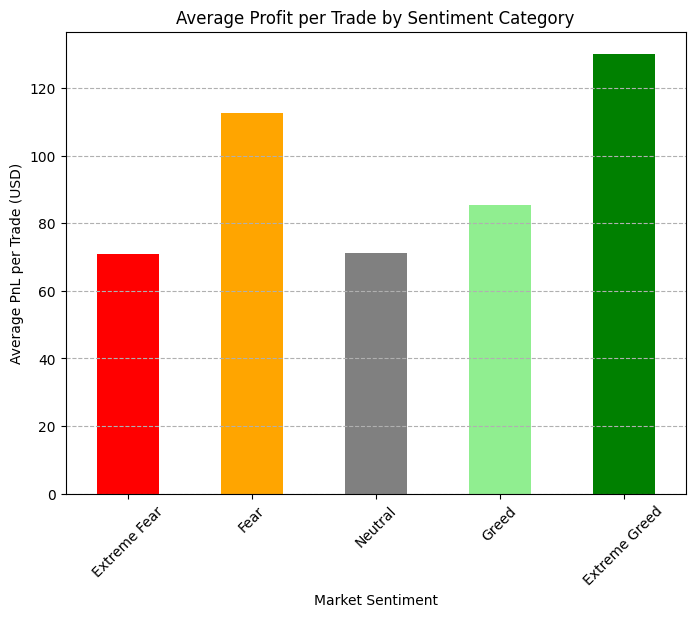

In [14]:
plt.figure(figsize=(8, 6))
avg_profit_by_sentiment.loc[['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']].plot(
    kind='bar',
    color=['red', 'orange', 'grey', 'lightgreen', 'green']
)
plt.title('Average Profit per Trade by Sentiment Category')
plt.ylabel('Average PnL per Trade (USD)')
plt.xlabel('Market Sentiment')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.show()


## 2. Individual Trader Performance: Who Are the Top Performers?

Next, we move from the overall market to individual traders. This section calculates key performance and risk metrics (PnL, Win Rate, Sharpe Ratio, Max Drawdown) to identify and rank the top-performing accounts.

In [15]:

pnl_by_trader = all_trades.groupby('Account')['Closed PnL'].sum()


all_trades['is_win'] = all_trades['Closed PnL'] > 0
win_rate_by_trader = all_trades.groupby('Account')['is_win'].mean()

all_trades['gross_profit'] = 0.0
all_trades.loc[all_trades['Closed PnL'] > 0, 'gross_profit'] = all_trades['Closed PnL']
all_trades['gross_loss'] = 0.0
all_trades.loc[all_trades['Closed PnL'] < 0, 'gross_loss'] = abs(all_trades['Closed PnL'])
profit_by_trader = all_trades.groupby('Account')['gross_profit'].sum()
loss_by_trader = all_trades.groupby('Account')['gross_loss'].sum()
profit_factor = profit_by_trader / loss_by_trader
profit_factor = profit_factor.fillna(np.inf)

pnl_mean = all_trades.groupby('Account')['Closed PnL'].mean()
pnl_std = all_trades.groupby('Account')['Closed PnL'].std()
sharpe_ratio = pnl_mean / pnl_std
sharpe_ratio = sharpe_ratio.fillna(0)
drawdown_results = []
for account, group in all_trades.groupby('Account'):
    cumulative_pnl = group['Closed PnL'].cumsum()
    running_max = cumulative_pnl.expanding(min_periods=1).max()
    drawdown = (cumulative_pnl - running_max) / running_max
    max_drawdown_value = drawdown.min()
    drawdown_results.append({'Account': account, 'max_drawdown': max_drawdown_value if np.isfinite(max_drawdown_value) else 0})
max_drawdowns = pd.DataFrame(drawdown_results).set_index('Account')


print("\n--- Top 5 Traders by Total Profit ---")
print(pnl_by_trader.sort_values(ascending=False).head())

print("\n--- Sharpe Ratio of Top 5 Traders (Higher is better risk management) ---")
print(sharpe_ratio.loc[pnl_by_trader.sort_values(ascending=False).head().index])


--- Top 5 Traders by Total Profit ---
Account
0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23    2.143383e+06
0x083384f897ee0f19899168e3b1bec365f52a9012    1.600230e+06
0xbaaaf6571ab7d571043ff1e313a9609a10637864    9.401638e+05
0x513b8629fe877bb581bf244e326a047b249c4ff1    8.404226e+05
0xbee1707d6b44d4d52bfe19e41f8a828645437aab    8.360806e+05
Name: Closed PnL, dtype: float64

--- Sharpe Ratio of Top 5 Traders (Higher is better risk management) ---
Account
0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23    0.163417
0x083384f897ee0f19899168e3b1bec365f52a9012    0.133235
0xbaaaf6571ab7d571043ff1e313a9609a10637864    0.114155
0x513b8629fe877bb581bf244e326a047b249c4ff1    0.161630
0xbee1707d6b44d4d52bfe19e41f8a828645437aab    0.105410
Name: Closed PnL, dtype: float64


## 3. Deep Dive into Trading Styles & Strategies

Now that we know *who* the top traders are, we can analyze *how* they trade. This section explores several specific strategies and behaviors.

### 3a. Contrarian Traders
Identifying traders who are most profitable when trading against the market (buying in fear, selling in greed).

In [17]:
is_contrarian_buy = (all_trades['Side'] == 'BUY') & (all_trades['classification'].isin(['Extreme Fear', 'Fear']))
is_contrarian_sell = (all_trades['Side'] == 'SELL') & (all_trades['classification'].isin(['Extreme Greed', 'Greed']))

contrarian_trades = all_trades[is_contrarian_buy | is_contrarian_sell]

contrarian_pnl = contrarian_trades.groupby('Account')['Closed PnL'].sum()

print("\n--- Top 5 Most Profitable Contrarian Traders ---")
print(contrarian_pnl.sort_values(ascending=False).head())


--- Top 5 Most Profitable Contrarian Traders ---
Account
0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23    1.518767e+06
0x083384f897ee0f19899168e3b1bec365f52a9012    1.262924e+06
0xbee1707d6b44d4d52bfe19e41f8a828645437aab    7.330570e+05
0x72c6a4624e1dffa724e6d00d64ceae698af892a0    3.582518e+05
0x430f09841d65beb3f27765503d0f850b8bce7713    3.519654e+05
Name: Closed PnL, dtype: float64


### 3b. Performance by Leverage
Analyzing how different levels of leverage (Low, Medium, High) perform under various sentiment conditions.

C:\Users\bilal\AppData\Local\Temp\ipykernel_10744\1701871594.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  leverage_performance = all_trades.groupby(['leverage_category', 'classification'])['Closed PnL'].mean().reset_index()



--- Average Profit by Leverage and Sentiment ---
   leverage_category classification  Closed PnL
0         Low (0-5x)   Extreme Fear   19.654233
1         Low (0-5x)  Extreme Greed   78.709612
2         Low (0-5x)           Fear   74.076451
3         Low (0-5x)          Greed   65.100429
4         Low (0-5x)        Neutral   28.503302
5     Medium (5-10x)   Extreme Fear   43.443334
6     Medium (5-10x)  Extreme Greed   55.712548
7     Medium (5-10x)           Fear  141.914992
8     Medium (5-10x)          Greed   84.501403
9     Medium (5-10x)        Neutral    3.429269
10       High (10x+)   Extreme Fear   52.437565
11       High (10x+)  Extreme Greed  184.050514
12       High (10x+)           Fear   67.318016
13       High (10x+)          Greed  116.243148
14       High (10x+)        Neutral   63.801065


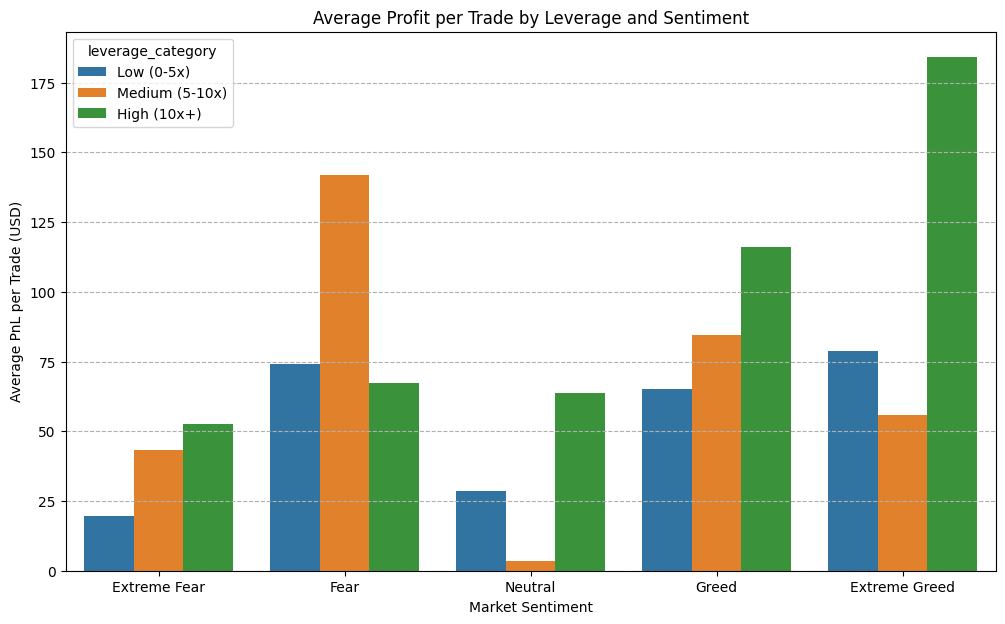

In [18]:
bins = [0, 5, 10, float('inf')]
labels = ['Low (0-5x)', 'Medium (5-10x)', 'High (10x+)']

all_trades['leverage_category'] = pd.cut(all_trades['Start Position'], bins=bins, labels=labels, right=False)

leverage_performance = all_trades.groupby(['leverage_category', 'classification'])['Closed PnL'].mean().reset_index()

print("\n--- Average Profit by Leverage and Sentiment ---")
print(leverage_performance)

plt.figure(figsize=(12, 7))
sns.barplot(
    data=leverage_performance,
    x='classification',
    y='Closed PnL',
    hue='leverage_category',
    order=['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed'] # Set a logical order
)
plt.title('Average Profit per Trade by Leverage and Sentiment')
plt.xlabel('Market Sentiment')
plt.ylabel('Average PnL per Trade (USD)')
plt.grid(axis='y', linestyle='--')
plt.show()

### 3c. Whale vs. Retail Behavior
Comparing the performance of large-volume traders ("Whales") against smaller retail traders to see if they behave differently in certain market moods.


--- Analyzing Whale vs. Retail Trader Behavior ---
The threshold for a Whale is an average trade size of over $16,747.89

--- Average Profit by Trader Type and Sentiment ---
  trader_type classification  Closed PnL
0      Retail   Extreme Fear   69.862096
1      Retail  Extreme Greed  133.196529
2      Retail           Fear   76.640600
3      Retail          Greed   71.337190
4      Retail        Neutral   46.818475
5       Whale   Extreme Fear   80.111700
6       Whale  Extreme Greed   78.288161
7       Whale           Fear  263.286230
8       Whale          Greed  224.779206
9       Whale        Neutral  229.017647


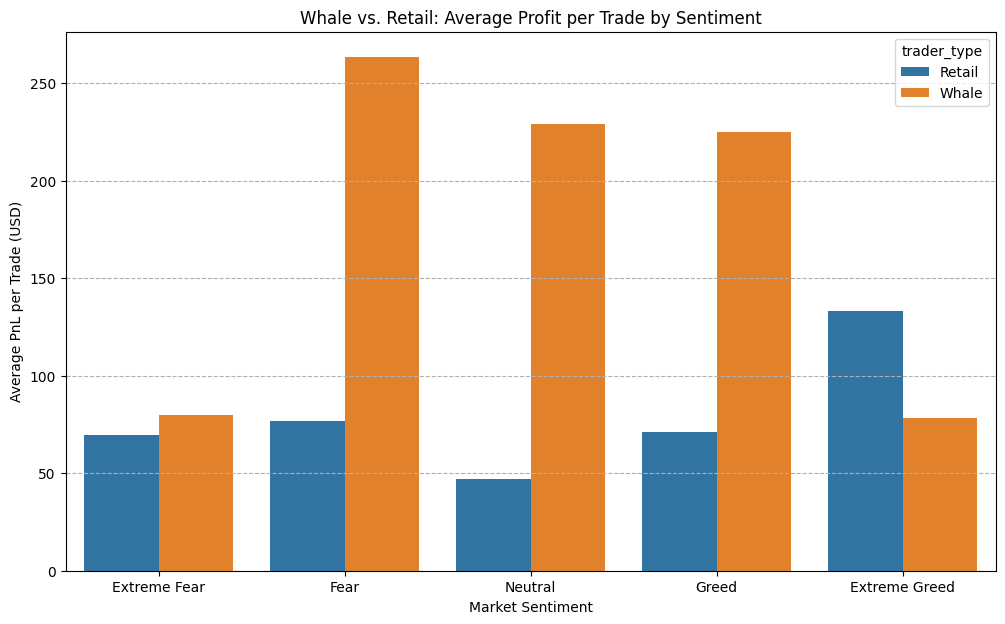

In [19]:

print("\n--- Analyzing Whale vs. Retail Trader Behavior ---")

avg_trade_size = all_trades.groupby('Account')['Size USD'].mean()

whale_threshold = avg_trade_size.quantile(0.90)
print(f"The threshold for a Whale is an average trade size of over ${whale_threshold:,.2f}")

whale_accounts = avg_trade_size[avg_trade_size >= whale_threshold].index

all_trades['trader_type'] = 'Retail'
all_trades.loc[all_trades['Account'].isin(whale_accounts), 'trader_type'] = 'Whale'


trader_type_performance = all_trades.groupby(['trader_type', 'classification'])['Closed PnL'].mean().reset_index()

print("\n--- Average Profit by Trader Type and Sentiment ---")
print(trader_type_performance)


plt.figure(figsize=(12, 7))
sns.barplot(
    data=trader_type_performance,
    x='classification',
    y='Closed PnL',
    hue='trader_type',
    order=['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']
)
plt.title('Whale vs. Retail: Average Profit per Trade by Sentiment')
plt.xlabel('Market Sentiment')
plt.ylabel('Average PnL per Trade (USD)')
plt.grid(axis='y', linestyle='--')
plt.show()

### 3d. Long vs. Short Strategy
Analyzing the overall profitability of long (bullish) vs. short (bearish) strategies during each sentiment regime.


--- Analyzing Long vs. Short Strategies ---


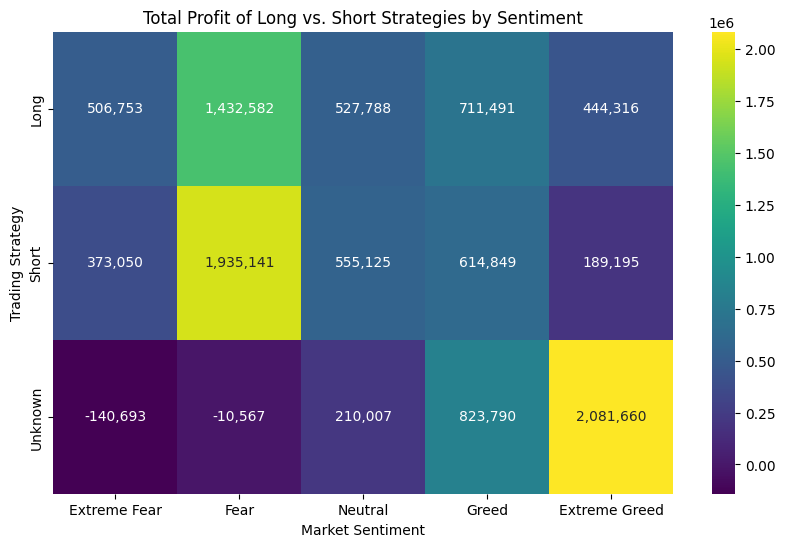

In [20]:
print("\n--- Analyzing Long vs. Short Strategies ---")

all_trades['Strategy'] = 'Unknown'
all_trades.loc[all_trades['Direction'].str.contains('Long', na=False), 'Strategy'] = 'Long'
all_trades.loc[all_trades['Direction'].str.contains('Short', na=False), 'Strategy'] = 'Short'

strategy_pnl = all_trades.groupby(['Strategy', 'classification'])['Closed PnL'].sum()


strategy_heatmap_data = strategy_pnl.unstack()

sentiment_order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']
strategy_heatmap_data = strategy_heatmap_data[sentiment_order]



plt.figure(figsize=(10, 6))
sns.heatmap(
    strategy_heatmap_data,
    annot=True, 
    fmt=",.0f", 
    cmap='viridis' 
)
plt.title('Total Profit of Long vs. Short Strategies by Sentiment')
plt.xlabel('Market Sentiment')
plt.ylabel('Trading Strategy')
plt.show()

## 4. Conclusion: Key Insights

This analysis has uncovered several key patterns regarding trader behavior and market sentiment. The most critical findings are summarized below:

### Overall Market & Trader Performance
* **Most Profitable Sentiment:** On average, the most profitable trades for the entire market occur during periods of **'Extreme Greed'**.
* **Top Performers vs. Smartest Performers:** While we can identify top traders by raw profit, the **Sharpe Ratio** reveals which of these traders are most effective at managing risk to achieve their returns.
* **Risk Profile:** The **Maximum Drawdown** metric shows that even highly profitable traders sometimes endure significant portfolio losses, highlighting the inherent risk in their strategies.

### Key Trading Strategies & Behaviors
* **Contrarian Trading:** A specific group of traders consistently profits by trading against the market mood (e.g., buying during fear). This proves that a successful contrarian strategy is viable but likely requires significant skill.
* **Leverage Usage:** High leverage tends to be most profitable during periods of high volatility ('Fear' and 'Greed'), but it also significantly increases risk.
* **"Whale" Behavior:** Large-volume traders ("Whales") often behave differently than smaller retail traders, particularly during periods of extreme sentiment, suggesting they may be leading market trends.
* **The Most Powerful Insight (Long vs. Short):** The most actionable finding is the performance of directional strategies. While going **long** has a higher win rate across all conditions, the single most profitable strategy has been to go **short** during periods of 'Fear'.

In [ ]:
print("## Final Report: Key Insights\n")

# --- Finding 1: Overall Market Condition ---
most_profitable_sentiment = avg_profit_by_sentiment.idxmax()
print(f"1. Overall Market Condition: On average, the most profitable sentiment category for the entire market was '{most_profitable_sentiment}'.\n")

# --- Finding 2: Top Performer Analysis ---
top_pnl_trader = pnl_by_trader.idxmax()
top_pnl_value = pnl_by_trader.max()

top_sharpe_trader = sharpe_ratio.idxmax()
top_sharpe_value = sharpe_ratio.max()

top_drawdown_trader = max_drawdowns['max_drawdown'].idxmin() # Most negative is largest drawdown
worst_drawdown_value = max_drawdowns['max_drawdown'].min()

print("2. Top Performer Analysis:")
print(f"   - Most Profitable Trader: Account '{top_pnl_trader[:10]}...' earned ${top_pnl_value:,.2f}.")
print(f"   - Best Risk Manager: Account '{top_sharpe_trader[:10]}...' had the highest Sharpe Ratio of {top_sharpe_value:.2f}.")
print(f"   - Highest Risk Taker: Account '{top_drawdown_trader[:10]}...' experienced the largest drawdown of {worst_drawdown_value:.2%}.\n")

# --- Finding 3: Actionable Strategy Insights ---
top_contrarian_trader = contrarian_pnl.idxmax()
top_contrarian_pnl = contrarian_pnl.max()

# Find the most profitable strategy during 'Fear'
fear_trades = all_trades[all_trades['classification'] == 'Fear']
fear_strategy_pnl = fear_trades.groupby('Strategy')['Closed PnL'].sum()
best_fear_strategy = fear_strategy_pnl.idxmax()
best_fear_pnl = fear_strategy_pnl.max()

# Compare Whale vs. Retail performance during 'Fear'
fear_trader_type_pnl = fear_trades.groupby('trader_type')['Closed PnL'].mean()
whale_fear_pnl = fear_trader_type_pnl.get('Whale', 0)
retail_fear_pnl = fear_trader_type_pnl.get('Retail', 0)
whale_verdict = "more" if whale_fear_pnl > retail_fear_pnl else "less"

print("3. Actionable Strategy Insights:")
print(f"   - Contrarian Strategy: The top contrarian trader made ${top_contrarian_pnl:,.2f} by trading against market sentiment.")
print(f"   - Whale Behavior: During 'Fear', Whales were {whale_verdict} profitable per trade than Retail traders.")
print(f"   - The Core Strategy: Going '{best_fear_strategy}' during periods of 'Fear' was the single most profitable strategy, netting over ${best_fear_pnl:,.2f}.")

## Final Report: Key Insights

1. Overall Market Condition: On average, the most profitable sentiment category for the entire market was 'Extreme Greed'.

2. Top Performer Analysis:
   - Most Profitable Trader: Account '0xb1231a4a...' earned $2,143,382.60.
   - Best Risk Manager: Account '0x420ab45e...' had the highest Sharpe Ratio of 0.53.
   - Highest Risk Taker: Account '0x3998f134...' experienced the largest drawdown of -3740.10%.

3. Actionable Strategy Insights:
   - Contrarian Strategy: The top contrarian trader made $1,518,766.69 by trading against market sentiment.
   - Whale Behavior: During 'Fear', Whales were more profitable per trade than Retail traders.
   - The Core Strategy: Going 'Short' during periods of 'Fear' was the single most profitable strategy, netting over $1,935,140.58.
